# 1. Importing libraries

In [79]:
import os
import numpy as np

import pandas as pd

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
	OneHotEncoder,
	OrdinalEncoder,
	StandardScaler,
	MinMaxScaler,
	PowerTransformer,
	FunctionTransformer
)

from feature_engine.outliers import Winsorizer
from feature_engine.datetime import DatetimeFeatures
from feature_engine.selection import SelectBySingleFeaturePerformance
from feature_engine.encoding import (
	RareLabelEncoder,
	MeanEncoder,
	CountFrequencyEncoder
)

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import GridSearchCV

# 2. Display Settings

In [80]:
pd.set_option("display.max_columns", None)

In [81]:
# by default transform's output are in numpy array, here we are changing it to pandas
sklearn.set_config(transform_output="pandas")

# 3. Read the data

In [82]:
path = '/home/pratik/Desktop/flight_price_sagemaker/data/train.csv'
train = pd.read_csv(path)
train.head()

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Jet Airways,2019-06-21,Mumbai,Hyderabad,10:20:00,11:50:00,90,0.0,In-flight meal not included,4995
1,Air India,2019-05-18,Delhi,Cochin,09:00:00,07:40:00,1360,1.0,No Info,8372
2,Air India,2019-06-12,Kolkata,Banglore,09:10:00,11:05:00,1555,2.0,No Info,6117
3,Vistara,2019-04-01,Kolkata,Banglore,20:20:00,22:55:00,1595,1.0,No Info,7770
4,Vistara,2019-06-06,Kolkata,Banglore,17:00:00,10:45:00,1065,1.0,No Info,9187


In [83]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          640 non-null    object 
 1   date_of_journey  640 non-null    object 
 2   source           640 non-null    object 
 3   destination      640 non-null    object 
 4   dep_time         640 non-null    object 
 5   arrival_time     640 non-null    object 
 6   duration         640 non-null    int64  
 7   total_stops      640 non-null    float64
 8   additional_info  640 non-null    object 
 9   price            640 non-null    int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 50.1+ KB


In [84]:
# train = train.dropna()

In [85]:
# train.shape

In [86]:
X_train = train.drop(columns="price")
y_train = train.price.copy()

In [87]:
X_train.isna().sum()

airline            0
date_of_journey    0
source             0
destination        0
dep_time           0
arrival_time       0
duration           0
total_stops        0
additional_info    0
dtype: int64

# 4. Transformation operations

### 4.1 airline

In [88]:
X_train.airline

0            Jet Airways
1              Air India
2              Air India
3                Vistara
4                Vistara
             ...        
635             Air Asia
636          Jet Airways
637               Indigo
638    Multiple Carriers
639          Jet Airways
Name: airline, Length: 640, dtype: object

In [89]:
air_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="most_frequent")),
	("grouper", RareLabelEncoder(tol=0.1, replace_with="Other", n_categories=2)),
	("encoder", OneHotEncoder(sparse_output=False, handle_unknown="ignore"))
])

air_transformer.fit_transform(X_train.loc[:, ["airline"]]) # .airline.value_counts()

,airline_Air India,airline_Indigo,airline_Jet Airways,airline_Multiple Carriers,airline_Other
0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...
635,0.0,0.0,0.0,0.0,1.0
636,0.0,0.0,1.0,0.0,0.0
637,0.0,1.0,0.0,0.0,0.0
638,0.0,0.0,0.0,1.0,0.0


### 4.2 date of journey

In [90]:
X_train.date_of_journey

0      2019-06-21
1      2019-05-18
2      2019-06-12
3      2019-04-01
4      2019-06-06
          ...    
635    2019-04-12
636    2019-05-09
637    2019-05-15
638    2019-05-15
639    2019-05-21
Name: date_of_journey, Length: 640, dtype: object

In [91]:
feat_to_extract = ['month', 'week', 'day_of_week', 'day_of_year']

doj_transformer = Pipeline(steps=[
    ('dt', DatetimeFeatures(features_to_extract=feat_to_extract, yearfirst=True, format='mixed')),
    ('scaler', MinMaxScaler())
])

doj_transformer.fit_transform(X_train.loc[:, ['date_of_journey']])

,date_of_journey_month,date_of_journey_week,date_of_journey_day_of_week,date_of_journey_day_of_year
0,1.000000,0.941176,0.666667,0.949153
1,0.666667,0.647059,0.833333,0.661017
2,1.000000,0.882353,0.333333,0.872881
3,0.333333,0.294118,0.000000,0.262712
4,1.000000,0.823529,0.500000,0.822034
...,...,...,...,...
635,0.333333,0.352941,0.666667,0.355932
636,0.666667,0.588235,0.500000,0.584746
637,0.666667,0.647059,0.333333,0.635593
638,0.666667,0.647059,0.333333,0.635593


### 4.3 source and destination

In [92]:
X_train.source

0        Mumbai
1         Delhi
2       Kolkata
3       Kolkata
4       Kolkata
         ...   
635    Banglore
636     Kolkata
637    Banglore
638       Delhi
639     Kolkata
Name: source, Length: 640, dtype: object

In [93]:
X_train.destination

0      Hyderabad
1         Cochin
2       Banglore
3       Banglore
4       Banglore
         ...    
635        Delhi
636     Banglore
637        Delhi
638       Cochin
639     Banglore
Name: destination, Length: 640, dtype: object

In [94]:
location_subset = X_train.loc[:, ["source", "destination"]]
location_subset

,source,destination
0,Mumbai,Hyderabad
1,Delhi,Cochin
2,Kolkata,Banglore
3,Kolkata,Banglore
4,Kolkata,Banglore
...,...,...
635,Banglore,Delhi
636,Kolkata,Banglore
637,Banglore,Delhi
638,Delhi,Cochin


In [95]:
location_pipe1 = Pipeline(steps=[
	("grouper", RareLabelEncoder(tol=0.1, replace_with="Other", n_categories=2)),

    # MeanEncoder() calculates avg(price) for each unique categories
	("encoder", MeanEncoder()),

    # Power transformer will try to make column as symmetric as possible
    # Also it does standardization
	("scaler", PowerTransformer())
])

location_pipe1.fit_transform(location_subset, y_train)

,source,destination
0,-1.855189,-0.904387
1,1.010384,1.009568
2,0.001513,-0.024692
3,0.001513,-0.024692
4,0.001513,-0.024692
...,...,...
635,-1.066757,-1.786597
636,0.001513,-0.024692
637,-1.066757,-1.786597
638,1.010384,1.009568


In [96]:
np.union1d(
    X_train.source.unique(),
    X_train.destination.unique()
)

array(['Banglore', 'Chennai', 'Cochin', 'Delhi', 'Hyderabad', 'Kolkata',
       'Mumbai', 'New Delhi'], dtype=object)

In [97]:
def is_north(X):
	columns = X.columns.to_list()
	north_cities = ["Delhi", "Kolkata", "Mumbai", "New Delhi"]
	return (
		X
		.assign(**{
			f"{col}_is_north": X.loc[:, col].isin(north_cities).astype(int)
			for col in columns
		})
		.drop(columns=columns)
	)


FunctionTransformer(func=is_north).fit_transform(location_subset)

,source_is_north,destination_is_north
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
...,...,...
635,0,1
636,1,0
637,0,1
638,1,0


In [98]:
location_transformer = FeatureUnion(transformer_list=[
	("part1", location_pipe1),
	("part2", FunctionTransformer(func=is_north))
])

location_transformer.fit_transform(location_subset, y_train)

,source,destination,source_is_north,destination_is_north
0,-1.855189,-0.904387,1,0
1,1.010384,1.009568,1,0
2,0.001513,-0.024692,1,0
3,0.001513,-0.024692,1,0
4,0.001513,-0.024692,1,0
...,...,...,...,...
635,-1.066757,-1.786597,0,1
636,0.001513,-0.024692,1,0
637,-1.066757,-1.786597,0,1
638,1.010384,1.009568,1,0


### 4.4 departure time and arrival time

In [99]:
X_train.dep_time

0      10:20:00
1      09:00:00
2      09:10:00
3      20:20:00
4      17:00:00
         ...   
635    04:55:00
636    09:35:00
637    06:05:00
638    08:45:00
639    20:00:00
Name: dep_time, Length: 640, dtype: object

In [100]:
X_train.arrival_time

0      11:50:00
1      07:40:00
2      11:05:00
3      22:55:00
4      10:45:00
         ...   
635    07:45:00
636    21:05:00
637    08:50:00
638    21:00:00
639    12:00:00
Name: arrival_time, Length: 640, dtype: object

In [101]:
time_subset = X_train.loc[:, ["dep_time", "arrival_time"]]
time_subset

,dep_time,arrival_time
0,10:20:00,11:50:00
1,09:00:00,07:40:00
2,09:10:00,11:05:00
3,20:20:00,22:55:00
4,17:00:00,10:45:00
...,...,...
635,04:55:00,07:45:00
636,09:35:00,21:05:00
637,06:05:00,08:50:00
638,08:45:00,21:00:00


In [102]:
time_pipe1 = Pipeline(steps=[
	("dt", DatetimeFeatures(features_to_extract=["hour", "minute"])),
	("scaler", MinMaxScaler())
])

time_pipe1.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute
0,0.434783,0.363636,0.478261,0.909091
1,0.391304,0.000000,0.304348,0.727273
2,0.391304,0.181818,0.478261,0.090909
3,0.869565,0.363636,0.956522,1.000000
4,0.739130,0.000000,0.434783,0.818182
...,...,...,...,...
635,0.173913,1.000000,0.304348,0.818182
636,0.391304,0.636364,0.913043,0.090909
637,0.260870,0.090909,0.347826,0.909091
638,0.347826,0.818182,0.913043,0.000000


In [103]:
def part_of_day(X, morning=4, noon=12, eve=16, night=20):
	columns = X.columns.to_list()
	X_temp = X.assign(**{
		col: pd.to_datetime(X.loc[:, col]).dt.hour
		for col in columns
	})

	return (
		X_temp
		.assign(**{
			f"{col}_part_of_day": np.select(
				[X_temp.loc[:, col].between(morning, noon, inclusive="left"),
				 X_temp.loc[:, col].between(noon, eve, inclusive="left"),
				 X_temp.loc[:, col].between(eve, night, inclusive="left")],
				["morning", "afternoon", "evening"],
				default="night"
			)
			for col in columns
		})
		.drop(columns=columns)
	)

FunctionTransformer(func=part_of_day).fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,morning,morning
1,morning,morning
2,morning,morning
3,night,night
4,evening,morning
...,...,...
635,morning,morning
636,morning,night
637,morning,morning
638,morning,night


In [104]:
time_pipe2 = Pipeline(steps=[
	("part", FunctionTransformer(func=part_of_day)),
	("encoder", CountFrequencyEncoder()),
	("scaler", MinMaxScaler())
])

time_pipe2.fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,1.000000,0.932584
1,1.000000,0.932584
2,1.000000,0.932584
3,0.135747,1.000000
4,0.185520,0.932584
...,...,...
635,1.000000,0.932584
636,1.000000,1.000000
637,1.000000,0.932584
638,1.000000,1.000000


In [105]:
time_transformer = FeatureUnion(transformer_list=[
	("part1", time_pipe1),
	("part2", time_pipe2)
])

time_transformer.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute,dep_time_part_of_day,arrival_time_part_of_day
0,0.434783,0.363636,0.478261,0.909091,1.000000,0.932584
1,0.391304,0.000000,0.304348,0.727273,1.000000,0.932584
2,0.391304,0.181818,0.478261,0.090909,1.000000,0.932584
3,0.869565,0.363636,0.956522,1.000000,0.135747,1.000000
4,0.739130,0.000000,0.434783,0.818182,0.185520,0.932584
...,...,...,...,...,...,...
635,0.173913,1.000000,0.304348,0.818182,1.000000,0.932584
636,0.391304,0.636364,0.913043,0.090909,1.000000,1.000000
637,0.260870,0.090909,0.347826,0.909091,1.000000,0.932584
638,0.347826,0.818182,0.913043,0.000000,1.000000,1.000000


### 4.5 duration

In [106]:
X_train.duration

0        90
1      1360
2      1555
3      1595
4      1065
       ... 
635     170
636     690
637     165
638     735
639     960
Name: duration, Length: 640, dtype: int64

In [107]:
(
	X_train
	.duration
	.quantile([0.25, 0.5, 0.75])
	.values
	.reshape(-1, 1)
	# .shape
)

array([[175.  ],
       [505.  ],
       [956.25]])

In [108]:
class RBFPercentileSimilarity(BaseEstimator, TransformerMixin):
	def __init__(self, variables=None, percentiles=[0.25, 0.5, 0.75], gamma=0.1):
		self.variables = variables
		self.percentiles = percentiles
		self.gamma = gamma


	def fit(self, X, y=None):
        # Checking if user has given variables or not
		if not self.variables:
            # selecting all numeric columns
			self.variables = X.select_dtypes(include="number").columns.to_list()

		self.reference_values_ = {
			col: (
				X
				.loc[:, col]
				.quantile(self.percentiles)
				.values
				.reshape(-1, 1)
			)
			for col in self.variables
		}

		return self


	def transform(self, X):
		objects = []
		for col in self.variables:
			columns = [f"{col}_rbf_{int(percentile * 100)}" for percentile in self.percentiles]
			obj = pd.DataFrame(
				data=rbf_kernel(X.loc[:, [col]], Y=self.reference_values_[col], gamma=self.gamma),
				columns=columns
			)
			objects.append(obj)
		return pd.concat(objects, axis=1)

In [109]:
RBFPercentileSimilarity(percentiles=[0.4, 0.8]).fit_transform(X_train)

,duration_rbf_40,duration_rbf_80,total_stops_rbf_40,total_stops_rbf_80
0,0.0,0.000000e+00,0.904837,0.904837
1,0.0,0.000000e+00,1.000000,1.000000
2,0.0,0.000000e+00,0.904837,0.904837
3,0.0,0.000000e+00,1.000000,1.000000
4,0.0,5.193201e-57,1.000000,1.000000
...,...,...,...,...
635,0.0,0.000000e+00,0.904837,0.904837
636,0.0,0.000000e+00,1.000000,1.000000
637,0.0,0.000000e+00,0.904837,0.904837
638,0.0,0.000000e+00,1.000000,1.000000


In [110]:
def duration_category(X, short=180, med=400):
	return (
		X
		.assign(duration_cat=np.select([X.duration.lt(short),
									    X.duration.between(short, med, inclusive="left")],
									   ["short", "medium"],
									   default="long"))
		.drop(columns="duration")
	)

In [111]:
def is_over(X, value=1000):
	return (
		X
		.assign(**{
			f"duration_over_{value}": X.duration.ge(value).astype(int)
		})
		.drop(columns="duration")
	)

In [112]:
duration_pipe1 = Pipeline(steps=[
	("rbf", RBFPercentileSimilarity()),
	("scaler", PowerTransformer())
])

duration_pipe2 = Pipeline(steps=[
	("cat", FunctionTransformer(func=duration_category)),
	("encoder", OrdinalEncoder(categories=[["short", "medium", "long"]]))
])

duration_union = FeatureUnion(transformer_list=[
	("part1", duration_pipe1),
	("part2", duration_pipe2),
	# ("part3", FunctionTransformer(func=is_over)),
	# ("part4", StandardScaler())
])

duration_transformer = Pipeline(steps=[
	("outliers", Winsorizer(capping_method="iqr", fold=1.5)),
	("imputer", SimpleImputer(strategy="median")),
	("union", duration_union)
])

duration_transformer.fit_transform(X_train.loc[:, ["duration"]])

,duration_rbf_25,duration_rbf_50,duration_rbf_75,duration_cat
0,-0.364072,-0.132454,-0.099279,0.0
1,-0.364072,-0.132454,-0.099279,2.0
2,-0.364072,-0.132454,-0.099279,2.0
3,-0.364072,-0.132454,-0.099279,2.0
4,-0.364072,-0.132454,-0.099279,2.0
...,...,...,...,...
635,2.649340,-0.132454,-0.099279,0.0
636,-0.364072,-0.132454,-0.099279,2.0
637,-0.359672,-0.132454,-0.099279,0.0
638,-0.364072,-0.132454,-0.099279,2.0


### 4.6 total stops

In [113]:
X_train.total_stops

0      0.0
1      1.0
2      2.0
3      1.0
4      1.0
      ... 
635    0.0
636    1.0
637    0.0
638    1.0
639    1.0
Name: total_stops, Length: 640, dtype: float64

In [114]:
def is_direct(X):
	return X.assign(is_direct_flight=X.total_stops.eq(0).astype(int))


total_stops_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="most_frequent")),
	("", FunctionTransformer(func=is_direct))
])

total_stops_transformer.fit_transform(X_train.loc[:, ["total_stops"]])

,total_stops,is_direct_flight
0,0.0,1
1,1.0,0
2,2.0,0
3,1.0,0
4,1.0,0
...,...,...
635,0.0,1
636,1.0,0
637,0.0,1
638,1.0,0


### 4.7 additional info

In [115]:
X_train.additional_info

0      In-flight meal not included
1                          No Info
2                          No Info
3                          No Info
4                          No Info
                  ...             
635                        No Info
636                        No Info
637                        No Info
638                        No Info
639    In-flight meal not included
Name: additional_info, Length: 640, dtype: object

In [116]:
info_pipe1 = Pipeline(steps=[
	("group", RareLabelEncoder(tol=0.1, n_categories=2, replace_with="Other")),
	("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

info_pipe1.fit_transform(X_train.loc[:, ["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other
0,1.0,0.0,0.0
1,0.0,1.0,0.0
2,0.0,1.0,0.0
3,0.0,1.0,0.0
4,0.0,1.0,0.0
...,...,...,...
635,0.0,1.0,0.0
636,0.0,1.0,0.0
637,0.0,1.0,0.0
638,0.0,1.0,0.0


In [117]:
def have_info(X):
	return X.assign(additional_info=X.additional_info.ne("No Info").astype(int))

In [118]:
info_union = FeatureUnion(transformer_list=[
	("part1", info_pipe1),
	("part2", FunctionTransformer(func=have_info))
])

In [119]:
info_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
	("union", info_union)
])

info_transformer.fit_transform(X_train.loc[:, ["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other,additional_info
0,1.0,0.0,0.0,1
1,0.0,1.0,0.0,0
2,0.0,1.0,0.0,0
3,0.0,1.0,0.0,0
4,0.0,1.0,0.0,0
...,...,...,...,...
635,0.0,1.0,0.0,0
636,0.0,1.0,0.0,0
637,0.0,1.0,0.0,0
638,0.0,1.0,0.0,0


In [120]:
X_train.isna().sum()

airline            0
date_of_journey    0
source             0
destination        0
dep_time           0
arrival_time       0
duration           0
total_stops        0
additional_info    0
dtype: int64

# 5. Column Transformer

In [121]:
col_transformer = ColumnTransformer(transformers=[
    ('air', air_transformer, ['airline']),
    ('doj', doj_transformer, ['date_of_journey']),
    ("location", location_transformer, ["source", 'destination']),
    ("time", time_transformer, ["dep_time", "arrival_time"]),
    ("dur", duration_transformer, ["duration"]),
	("stops", total_stops_transformer, ["total_stops"]),
	("info", info_transformer, ["additional_info"])
], remainder='passthrough')

col_transformer.fit_transform(X_train, y_train)

,air__airline_Air India,air__airline_Indigo,air__airline_Jet Airways,air__airline_Multiple Carriers,air__airline_Other,doj__date_of_journey_month,doj__date_of_journey_week,doj__date_of_journey_day_of_week,doj__date_of_journey_day_of_year,location__source,location__destination,location__source_is_north,location__destination_is_north,time__dep_time_hour,time__dep_time_minute,time__arrival_time_hour,time__arrival_time_minute,time__dep_time_part_of_day,time__arrival_time_part_of_day,dur__duration_rbf_25,dur__duration_rbf_50,dur__duration_rbf_75,dur__duration_cat,stops__total_stops,stops__is_direct_flight,info__additional_info_In-flight meal not included,info__additional_info_No Info,info__additional_info_Other,info__additional_info
0,0.0,0.0,1.0,0.0,0.0,1.000000,0.941176,0.666667,0.949153,-1.855189,-0.904387,1,0,0.434783,0.363636,0.478261,0.909091,1.000000,0.932584,-0.364072,-0.132454,-0.099279,0.0,0.0,1,1.0,0.0,0.0,1
1,1.0,0.0,0.0,0.0,0.0,0.666667,0.647059,0.833333,0.661017,1.010384,1.009568,1,0,0.391304,0.000000,0.304348,0.727273,1.000000,0.932584,-0.364072,-0.132454,-0.099279,2.0,1.0,0,0.0,1.0,0.0,0
2,1.0,0.0,0.0,0.0,0.0,1.000000,0.882353,0.333333,0.872881,0.001513,-0.024692,1,0,0.391304,0.181818,0.478261,0.090909,1.000000,0.932584,-0.364072,-0.132454,-0.099279,2.0,2.0,0,0.0,1.0,0.0,0
3,0.0,0.0,0.0,0.0,1.0,0.333333,0.294118,0.000000,0.262712,0.001513,-0.024692,1,0,0.869565,0.363636,0.956522,1.000000,0.135747,1.000000,-0.364072,-0.132454,-0.099279,2.0,1.0,0,0.0,1.0,0.0,0
4,0.0,0.0,0.0,0.0,1.0,1.000000,0.823529,0.500000,0.822034,0.001513,-0.024692,1,0,0.739130,0.000000,0.434783,0.818182,0.185520,0.932584,-0.364072,-0.132454,-0.099279,2.0,1.0,0,0.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,0.0,0.0,0.0,0.0,1.0,0.333333,0.352941,0.666667,0.355932,-1.066757,-1.786597,0,1,0.173913,1.000000,0.304348,0.818182,1.000000,0.932584,2.649340,-0.132454,-0.099279,0.0,0.0,1,0.0,1.0,0.0,0
636,0.0,0.0,1.0,0.0,0.0,0.666667,0.588235,0.500000,0.584746,0.001513,-0.024692,1,0,0.391304,0.636364,0.913043,0.090909,1.000000,1.000000,-0.364072,-0.132454,-0.099279,2.0,1.0,0,0.0,1.0,0.0,0
637,0.0,1.0,0.0,0.0,0.0,0.666667,0.647059,0.333333,0.635593,-1.066757,-1.786597,0,1,0.260870,0.090909,0.347826,0.909091,1.000000,0.932584,-0.359672,-0.132454,-0.099279,0.0,0.0,1,0.0,1.0,0.0,0
638,0.0,0.0,0.0,1.0,0.0,0.666667,0.647059,0.333333,0.635593,1.010384,1.009568,1,0,0.347826,0.818182,0.913043,0.000000,1.000000,1.000000,-0.364072,-0.132454,-0.099279,2.0,1.0,0,0.0,1.0,0.0,0


In [44]:
# You always underestimate things you can do in a month,
# and overestimate things you can do in a day

In [122]:
estimator = RandomForestRegressor(n_estimators=10, max_depth=3, random_state=42)

selector = SelectBySingleFeaturePerformance(
	estimator=estimator,
	scoring="r2",
	threshold=0.1
) 

In [123]:
preprocessor = Pipeline(steps=[
	("ct", col_transformer),
	("selector", selector)
])

preprocessor.fit_transform(X_train, y_train)

,air__airline_Indigo,air__airline_Jet Airways,air__airline_Other,doj__date_of_journey_week,doj__date_of_journey_day_of_year,location__source,location__destination,dur__duration_rbf_25,dur__duration_cat,stops__total_stops,stops__is_direct_flight
0,0.0,1.0,0.0,0.941176,0.949153,-1.855189,-0.904387,-0.364072,0.0,0.0,1
1,0.0,0.0,0.0,0.647059,0.661017,1.010384,1.009568,-0.364072,2.0,1.0,0
2,0.0,0.0,0.0,0.882353,0.872881,0.001513,-0.024692,-0.364072,2.0,2.0,0
3,0.0,0.0,1.0,0.294118,0.262712,0.001513,-0.024692,-0.364072,2.0,1.0,0
4,0.0,0.0,1.0,0.823529,0.822034,0.001513,-0.024692,-0.364072,2.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...
635,0.0,0.0,1.0,0.352941,0.355932,-1.066757,-1.786597,2.649340,0.0,0.0,1
636,0.0,1.0,0.0,0.588235,0.584746,0.001513,-0.024692,-0.364072,2.0,1.0,0
637,1.0,0.0,0.0,0.647059,0.635593,-1.066757,-1.786597,-0.359672,0.0,0.0,1
638,0.0,0.0,0.0,0.647059,0.635593,1.010384,1.009568,-0.364072,2.0,1.0,0


In [125]:
import pickle
file_name = "preprocessor.pkl"

# save
# pickle.dump(preprocessor, open('/home/pratik/Desktop/flight_price_sagemaker/models/preprocessor.pkl', "wb"))

# load
loaded_preprocessor = pickle.load(open('/home/pratik/Desktop/flight_price_sagemaker/models/preprocessor.pkl', "rb"))

In [ ]:
# pickle.dump(preprocessor, "preprocessor.joblib")

In [126]:
feature_performances = loaded_preprocessor.named_steps["selector"].feature_performance_
feature_performances

{'air__airline_Air India': -0.0004934775676132356,
 'air__airline_Indigo': 0.11143357665144797,
 'air__airline_Jet Airways': 0.14506076487015315,
 'air__airline_Multiple Carriers': -0.003073250116394773,
 'air__airline_Other': 0.10720239661922266,
 'doj__date_of_journey_month': 0.07587871136576778,
 'doj__date_of_journey_week': 0.17309192040384677,
 'doj__date_of_journey_day_of_week': -0.019500664285657814,
 'doj__date_of_journey_day_of_year': 0.20504259758740517,
 'location__source': 0.14743682918716292,
 'location__destination': 0.15866333325687323,
 'location__source_is_north': 0.04359756801151038,
 'location__destination_is_north': 0.04359756801151038,
 'time__dep_time_hour': -0.022199415197866428,
 'time__dep_time_minute': 0.026288954687537263,
 'time__arrival_time_hour': 0.07200269878055865,
 'time__arrival_time_minute': 0.011447444082674988,
 'time__dep_time_part_of_day': -0.008058685914884345,
 'time__arrival_time_part_of_day': 0.014250114500499103,
 'dur__duration_rbf_25': 0.1

In [127]:
sorted_feat_imp = dict(sorted(feature_performances.items(), key=lambda val: val[1]))
len(sorted_feat_imp)

29

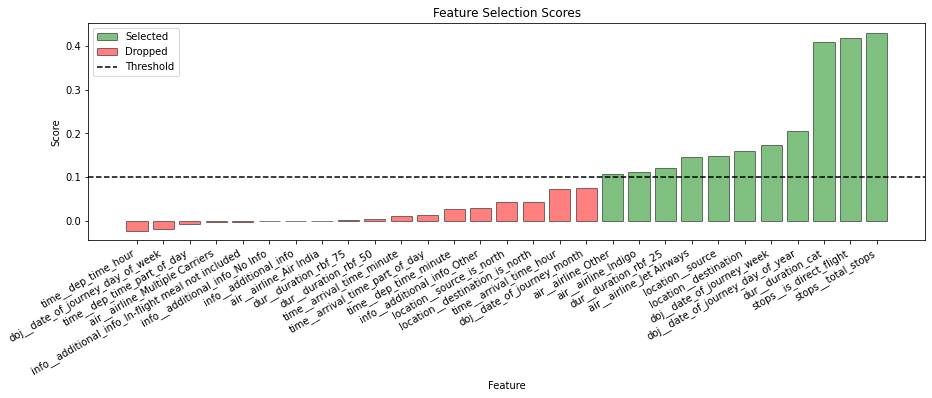

In [128]:
THRESHOLD = 0.1

selected_bar = None
dropped_bar = None
colors = ["red" if score < THRESHOLD else "green" for score in sorted_feat_imp.values()]


fig, ax = plt.subplots(figsize=(15, 4)) 

for i, (feature, score) in enumerate(sorted_feat_imp.items()):
	params = dict(
		x=i,
		height=score,
		edgecolor="black",
		alpha=0.5
	)
	
	if score < THRESHOLD:
		bar = ax.bar(
			color="red",
			**params
		)
		if not dropped_bar:
			dropped_bar = bar[0]
	else:
		bar = ax.bar(
			color="green",
			**params
		)
		if not selected_bar:
			selected_bar = bar[0]

thresh_line = ax.axhline(
	y=0.1,
	color="black",
	linestyle="--"
)
ax.set_xticks(
	ticks=range(len(sorted_feat_imp)),
	labels=list(sorted_feat_imp.keys()),
	rotation=30,
	ha="right"
)

ax.set(
	xlabel="Feature",
	ylabel="Score",
	title="Feature Selection Scores"
)

ax.legend(
	handles=[selected_bar, dropped_bar, thresh_line],
	labels=["Selected", "Dropped", "Threshold"],
	loc="upper left"
)

plt.show()

# Model training

In [52]:
PROJECT_DIR = "/home/pratik/Desktop/flight_price_sagemaker"
DATA_DIR = "preprocessed_data"

In [129]:
def export_data(data, name, pre):
    
    X = data.drop(columns='price')
    y = data.price.copy()
    
    X_pre = pre.transform(X)
    file_name = f"{name}.csv"
    file_path = os.path.join(PROJECT_DIR, DATA_DIR, file_name)
    X_pre.join(y).to_csv(file_path, index=False)
    return pd.read_csv(file_path).head()

In [130]:
export_data(train, "preprocessed_train", loaded_preprocessor)

,air__airline_Indigo,air__airline_Jet Airways,air__airline_Other,doj__date_of_journey_week,doj__date_of_journey_day_of_year,location__source,location__destination,dur__duration_rbf_25,dur__duration_cat,stops__total_stops,stops__is_direct_flight,price
0,0.0,1.0,0.0,0.941176,0.949153,-1.855189,-0.904387,-0.364072,0.0,0.0,1,4995
1,0.0,0.0,0.0,0.647059,0.661017,1.010384,1.009568,-0.364072,2.0,1.0,0,8372
2,0.0,0.0,0.0,0.882353,0.872881,0.001513,-0.024692,-0.364072,2.0,2.0,0,6117
3,0.0,0.0,1.0,0.294118,0.262712,0.001513,-0.024692,-0.364072,2.0,1.0,0,7770
4,0.0,0.0,1.0,0.823529,0.822034,0.001513,-0.024692,-0.364072,2.0,1.0,0,9187


In [53]:
val = pd.read_csv('/home/pratik/Desktop/flight_price_sagemaker/data/val.csv')
val.sample()

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
137,Jet Airways,2019-05-15,Kolkata,Banglore,09:35:00,14:25:00,1730,1.0,In-flight meal not included,9314


In [131]:
export_data(val, "preprocessed_val", loaded_preprocessor)

,air__airline_Indigo,air__airline_Jet Airways,air__airline_Other,doj__date_of_journey_week,doj__date_of_journey_day_of_year,location__source,location__destination,dur__duration_rbf_25,dur__duration_cat,stops__total_stops,stops__is_direct_flight,price
0,0.0,0.0,0.0,0.764706,0.779661,1.010384,1.009568,-0.364072,2.0,3.0,0,10703
1,0.0,0.0,0.0,0.000000,0.016949,1.010384,1.009568,-0.364072,2.0,2.0,0,17266
2,0.0,0.0,0.0,0.058824,0.042373,-1.855189,-0.904387,-0.364072,2.0,1.0,0,10366
3,0.0,0.0,1.0,0.823529,0.847458,0.001513,-0.024692,-0.364072,2.0,1.0,0,9495
4,0.0,1.0,0.0,0.823529,0.796610,1.010384,1.009568,-0.364072,2.0,1.0,0,14714


In [132]:
test = pd.read_csv('/home/pratik/Desktop/flight_price_sagemaker/data/test.csv')
test.sample()

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
72,Air Asia,2019-06-06,Kolkata,Banglore,07:35:00,19:25:00,710,1.0,No Info,6810


In [133]:
export_data(test, "preprocessed_test", loaded_preprocessor)

,air__airline_Indigo,air__airline_Jet Airways,air__airline_Other,doj__date_of_journey_week,doj__date_of_journey_day_of_year,location__source,location__destination,dur__duration_rbf_25,dur__duration_cat,stops__total_stops,stops__is_direct_flight,price
0,0.0,0.0,0.0,0.000000,0.016949,1.010384,1.009568,-0.364072,2.0,1.0,0,18916
1,0.0,1.0,0.0,0.764706,0.779661,1.010384,1.009568,-0.364072,2.0,1.0,0,10262
2,0.0,0.0,0.0,0.823529,0.822034,1.010384,1.009568,-0.364072,2.0,1.0,0,9646
3,0.0,0.0,0.0,0.176471,0.194915,0.001513,-0.024692,-0.364072,2.0,1.0,0,14641
4,0.0,0.0,0.0,0.764706,0.737288,1.010384,1.009568,-0.364072,2.0,1.0,0,9794


In [134]:
from xgboost import XGBRegressor

In [135]:
xgb = XGBRegressor()

In [136]:
pre_train = pd.read_csv('/home/pratik/Desktop/flight_price_sagemaker/preprocessed_data/preprocessed_train.csv')
pre_train.sample()

,air__airline_Indigo,air__airline_Jet Airways,air__airline_Other,doj__date_of_journey_week,doj__date_of_journey_day_of_year,location__source,location__destination,dur__duration_rbf_25,dur__duration_cat,stops__total_stops,stops__is_direct_flight,price
415,0.0,0.0,0.0,0.176471,0.194915,0.001513,-0.024692,-0.364072,2.0,1.0,0,10493


In [137]:
X = pre_train.drop(columns = 'price')
y = pre_train.price.copy()

In [138]:
model = xgb.fit(X, y)

In [139]:
y_pred = model.predict(X)

In [140]:
r2_score(y, y_pred)

0.8681483268737793

In [62]:
pre_val = pd.read_csv('/home/pratik/Desktop/flight_price_sagemaker/preprocessed_data/preprocessed_val.csv')
pre_val.sample()

,air__airline_Indigo,air__airline_Jet Airways,air__airline_Other,doj__date_of_journey_week,doj__date_of_journey_day_of_year,location__source,location__destination,dur__duration_rbf_25,dur__duration_cat,stops__total_stops,stops__is_direct_flight,price
11,0.0,0.0,1.0,1.0,1.0,-1.066757,-1.786597,2.64934,0.0,0.0,1,4668


In [63]:
y_pred_val = model.predict(pre_val.iloc[:, :-1])

In [64]:
r2_score(pre_val.iloc[:, -1], y_pred_val)

0.6391745209693909

In [65]:
pre_test = pd.read_csv('/home/pratik/Desktop/flight_price_sagemaker/preprocessed_data/preprocessed_test.csv')
pre_test.sample()

,air__airline_Indigo,air__airline_Jet Airways,air__airline_Other,doj__date_of_journey_week,doj__date_of_journey_day_of_year,location__source,location__destination,dur__duration_rbf_25,dur__duration_cat,stops__total_stops,stops__is_direct_flight,price
154,0.0,0.0,0.0,0.058824,0.042373,1.010384,1.009568,-0.364072,2.0,2.0,0,11552


In [66]:
y_pred_test = model.predict(pre_test.iloc[:, :-1])

In [67]:
r2_score(pre_test.iloc[:, -1], y_pred_test)

0.6885987520217896

In [ ]:
param_test1 = {
 'n_estimators':range(100, 500, 50),
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}

In [ ]:
gsearch1 = GridSearchCV(estimator = XGBRegressor(n_estimators=140, max_depth=5,
                                                 min_child_weight=1), 
                                                 param_grid = param_test1, scoring='r2',n_jobs=-1, cv=5)

In [ ]:
gsearch1.fit(X, y)
gsearch1.best_params_, gsearch1.best_score_

In [142]:
test_data_path = '/home/pratik/Desktop/flight_price_sagemaker/data/test.csv'
t = pd.read_csv(test_data_path)
test = t.drop(columns='price')
o = test.head(1)
o

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info
0,Multiple Carriers,2019-03-03,Delhi,Cochin,18:15:00,01:35:00,440,1.0,No Info


In [143]:
# saved_preprocessor = joblib.load("/home/pratik/Desktop/flight_price_sagemaker/preprocessor.joblib")
x_new_pre = preprocessor.transform(o)

In [144]:
x_new_pre

,air__airline_Indigo,air__airline_Jet Airways,air__airline_Other,doj__date_of_journey_week,doj__date_of_journey_day_of_year,location__source,location__destination,dur__duration_rbf_25,dur__duration_cat,stops__total_stops,stops__is_direct_flight
0,0.0,0.0,0.0,0.0,0.016949,1.010384,1.009568,-0.364072,2.0,1.0,0


In [141]:
import pickle
file_name = "/home/pratik/Desktop/flight_price_sagemaker/models/xgb_reg.pkl"

# # save
pickle.dump(model, open(file_name, "wb"))

# load
xgb_model_loaded = pickle.load(open(file_name, "rb"))

In [147]:
xgb_model_loaded.predict(x_new_pre)[0]

14218.232